# Group Project - Internet Price Analysis Notebook
In this notebook I will investigate the hypothesis that 'For countries where the internet penetration rate is higher, the internet is seen as less of a luxury item'.

## Table of Contents
1. [Imports](#imports)
2. [Data Cleaning](#datacleaning)
4. [Analysis](#datavisualisation)
5. [Is the internet a luxury?](#conclusion)


## Import Statements and Data Loading <a name="imports"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [2]:
# Load the data files from the google drive
#dataset_file_path = '/content/drive/My Drive/Data/internet_and_development_13122023.csv'
dataset_file_path = 'data/internet_and_development_13122023.csv'
df = pd.read_csv(dataset_file_path)

#cost_of_living_file_path = '/content/drive/My Drive/Data/cost_of_living.csv' # Secondary data, unlinked to main dataset.
cost_of_living_file_path = 'data/cost_of_living.csv'
cost_of_living = pd.read_csv(cost_of_living_file_path)

In [3]:
#Set up the default settings for all of the visualisations:

# Reset Seaborn settings
sns.set()
# Reset Matplotlib settings
plt.rcdefaults()

# # Define custom colors for each region

color_list = ['#97D2FF','#7BCE23','#26CE23','#23CE76','#23CECC','#237BCE','#2325CE']

region_color_dict = {
    'Asia & Pacific': '#7BCE23',
    'Europe': '#26CE23',
    'Arab States': '#23CE76',
    'Africa': '#23CECC',
    'The Americas': '#237BCE',
    'CIS': '#2325CE'
}

# Create a regional color palette using the defined colors
regional_palette = [region_color_dict[region] for region in region_color_dict]

sns.set_palette(color_list)

#Set the default background colours for all visualisations
plt.rcParams['figure.facecolor'] = '#EEFFFE'

## Data Cleaning <a name="datacleaning"></a>

In [4]:
# I only need the relevant columns for this analysis
price_data = df[['Country', 'Year', 'Individuals using the Internet, total (%)', 'Internet_Price', 'Internet Price Ratio']]
price_data = price_data.sort_values(by=['Country', 'Year'])
# price_data.head()

In [5]:
# The following years are outside of the range of the dataset we are considering
# The null counts are huge and won't have useful data with that much missing
nan_count_2021 = df[df['Year'] == 2021]['Internet_Price'].isnull().sum()
nan_count_2022 = df[df['Year'] == 2022]['Internet_Price'].isnull().sum()
nan_count_2023 = df[df['Year'] == 2023]['Internet_Price'].isnull().sum()

In [6]:
# I drop these years from the data
years_to_drop = [2021, 2022, 2023]
price_data = price_data[~price_data['Year'].isin(years_to_drop)]
#price_data

The full merged dataset contains more countries than the original internet price dataset. I need to find a balance between how many to keep without losing so much data that the results are inconsistent.

In [7]:
missing_values_per_country = price_data.groupby('Country')['Internet_Price'].apply(lambda x: x.isnull().sum()).reset_index()
# missing_values_per_country

# Where the majority of the time series data is missing I drop that country from the dataset
countries_to_drop = missing_values_per_country[missing_values_per_country['Internet_Price'] > 6]['Country']
countries_to_drop

0              Afghanistan
3                  Andorra
4                   Angola
5      Antigua and Barbuda
14                Barbados
              ...         
182                 Uganda
188             Uzbekistan
189                Vanuatu
193                  Yemen
194                 Zambia
Name: Country, Length: 96, dtype: object

In [8]:
df_filt = price_data[~price_data['Country'].isin(countries_to_drop)]
df_filt.reset_index(drop=True, inplace=True)
df_filt

,Country,Year,"Individuals using the Internet, total (%)",Internet_Price,Internet Price Ratio
0,Albania,2010,45.000000,NaN,NaN
1,Albania,2011,47.000000,46.887617,1.063211
2,Albania,2012,49.400000,24.351196,0.558514
3,Albania,2013,51.800000,22.474050,0.495023
4,Albania,2014,54.300000,24.886662,0.548164
...,...,...,...,...,...
1088,Zimbabwe,2016,23.119989,95.800000,7.983333
1089,Zimbabwe,2017,24.400000,111.600000,9.538462
1090,Zimbabwe,2018,25.000000,119.666667,7.720430
1091,Zimbabwe,2019,26.588274,NaN,NaN


In [9]:
# function to impute NaN with the median of adjacent values ONLY from the same country
def fill_na_with_country_median(df):
    for col in df.columns:
        for i in range(1, len(df[col])-1):
            if pd.isnull(df[col].iloc[i]):
                current_country = df['Country'].iloc[i]
                # Don't want to mix up country values
                if current_country == df['Country'].iloc[i-1] and current_country == df['Country'].iloc[i+1]:
                    if not pd.isnull(df[col].iloc[i-1]) and not pd.isnull(df[col].iloc[i+1]):
                        df[col].iloc[i] = np.median([df[col].iloc[i-1], df[col].iloc[i+1]])
    return df

df_imputed = fill_na_with_country_median(df_filt)
df_imputed

/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/4080653178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].iloc[i] = np.median([df[col].iloc[i-1], df[col].iloc[i+1]])
/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/4080653178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].iloc[i] = np.median([df[col].iloc[i-1], df[col].iloc[i+1]])
/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/4080653178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

,Country,Year,"Individuals using the Internet, total (%)",Internet_Price,Internet Price Ratio
0,Albania,2010,45.000000,NaN,NaN
1,Albania,2011,47.000000,46.887617,1.063211
2,Albania,2012,49.400000,24.351196,0.558514
3,Albania,2013,51.800000,22.474050,0.495023
4,Albania,2014,54.300000,24.886662,0.548164
...,...,...,...,...,...
1088,Zimbabwe,2016,23.119989,95.800000,7.983333
1089,Zimbabwe,2017,24.400000,111.600000,9.538462
1090,Zimbabwe,2018,25.000000,119.666667,7.720430
1091,Zimbabwe,2019,26.588274,112.250000,7.450398


In [10]:
# Now i will drop any other null values rows from the data
df_clean = df_imputed.dropna()
df_clean # This is now the dataset I will use for analysis

,Country,Year,"Individuals using the Internet, total (%)",Internet_Price,Internet Price Ratio
1,Albania,2011,47.000000,46.887617,1.063211
2,Albania,2012,49.400000,24.351196,0.558514
3,Albania,2013,51.800000,22.474050,0.495023
4,Albania,2014,54.300000,24.886662,0.548164
5,Albania,2015,56.900000,15.863821,0.361363
...,...,...,...,...,...
1088,Zimbabwe,2016,23.119989,95.800000,7.983333
1089,Zimbabwe,2017,24.400000,111.600000,9.538462
1090,Zimbabwe,2018,25.000000,119.666667,7.720430
1091,Zimbabwe,2019,26.588274,112.250000,7.450398


## Data Visualisation <a name="datavisualisation"></a>


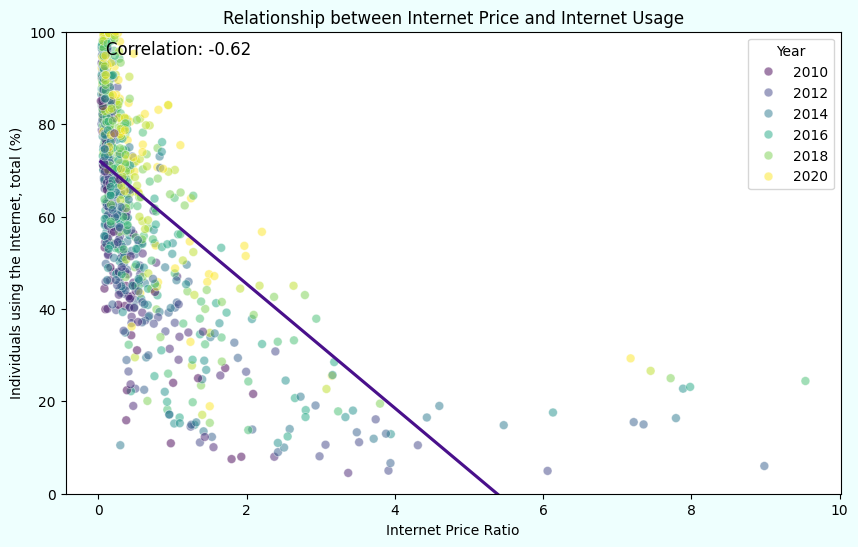

In [11]:
# Set the size of the figure
plt.figure(figsize=(10, 6))
plt.ylim(0, 100)

# Create the scatterplot with smaller dot size and transparency
sns.scatterplot(
    x='Internet Price Ratio',
    y='Individuals using the Internet, total (%)',
    hue='Year',
    palette='viridis',
    data=df_clean,
    s=40,  # Set the size of the markers
    alpha=0.5  # Set the transparency of the markers
)
sns.regplot(
    x='Internet Price Ratio',
    y='Individuals using the Internet, total (%)',
    data=df_clean,
    scatter=False,  # Prevents scatterplot duplicate
    color='#49108B',  # Color of the regression line
    ci=None
)
pmcc = df_clean['Internet Price Ratio'].corr(df_clean['Individuals using the Internet, total (%)'])
# Set labels and title
plt.xlabel('Internet Price Ratio')
plt.ylabel('Individuals using the Internet, total (%)')
plt.title('Relationship between Internet Price and Internet Usage')
plt.text(0.1, 95, f'Correlation: {pmcc:.2f}', fontsize=12, color='black')
# Show the plot
plt.show()

The scatter plot shows a negative correlation between the internet price ratio and the internet penetration rate. The plot does however indicate that a linear relationship may not be suitable for this data as the points show more as curved than linear and have a vary more away from the regression line. Therefore I investigate a log-linear model to fit to the data for the internet price ratio.



/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/975965288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Log Internet Price'] = np.log(df_clean['Internet Price Ratio'])
/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/975965288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Log Penetration Rate'] = np.log(df_clean['Individuals using the Internet, total (%)'])


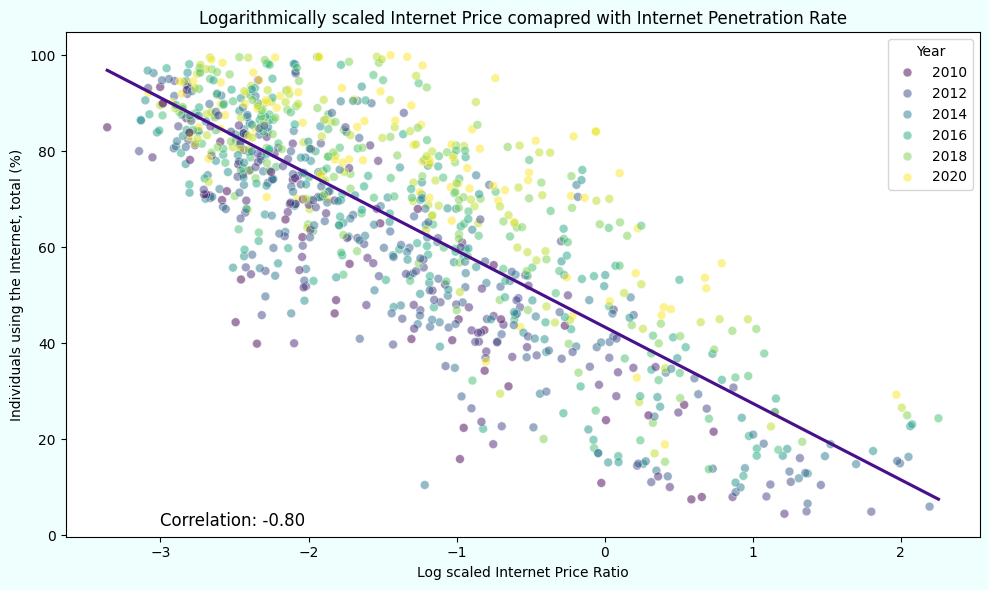

In [12]:
# Set the size of the figure
plt.figure(figsize=(10, 6))

df_clean['Log Internet Price'] = np.log(df_clean['Internet Price Ratio'])
df_clean['Log Penetration Rate'] = np.log(df_clean['Individuals using the Internet, total (%)'])

# Create the scatterplot with smaller dot size and transparency
sns.scatterplot(
    x='Log Internet Price',
    y='Individuals using the Internet, total (%)',
    hue='Year',
    palette='viridis',
    data=df_clean,
    s=40,  # Set the size of the markers
    alpha=0.5  # Set the transparency of the markers
)
sns.regplot(
    x='Log Internet Price',
    y='Individuals using the Internet, total (%)',
    data=df_clean,
    scatter=False,  # Prevents scatterplot duplicate
    color='#49108B',  # Color of the regression line
    ci=None
)
pmcc = df_clean['Log Internet Price'].corr(df_clean['Individuals using the Internet, total (%)'])
# Set labels and title
# Set logarithmic scale for both x and y axes
plt.xlabel('Log scaled Internet Price Ratio')
plt.ylabel('Individuals using the Internet, total (%)')
plt.title('Logarithmically scaled Internet Price comapred with Internet Penetration Rate')
plt.text(-3, 2, f'Correlation: {pmcc:.2f}', fontsize=12, color='black')

# Show the plot
plt.tight_layout()
plt.show()


In order to work effectively with the data, I aim to categorise each internet price ratio by it's afforability, I.e High, Moderate, Fair, Low, Limited.

In [13]:
percentiles = np.percentile(df_clean['Internet Price Ratio'], np.arange(0, 101, 20))
categories = ['High', 'Moderate', 'Fair', 'Low', 'Limited']
df_clean['Price Accessibility'] = pd.cut(df_clean['Internet Price Ratio'], bins=percentiles, labels=categories)
df_clean

/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/214300455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Price Accessibility'] = pd.cut(df_clean['Internet Price Ratio'], bins=percentiles, labels=categories)


,Country,Year,"Individuals using the Internet, total (%)",Internet_Price,Internet Price Ratio,Log Internet Price,Log Penetration Rate,Price Accessibility
1,Albania,2011,47.000000,46.887617,1.063211,0.061294,3.850148,Limited
2,Albania,2012,49.400000,24.351196,0.558514,-0.582476,3.899950,Low
3,Albania,2013,51.800000,22.474050,0.495023,-0.703151,3.947390,Low
4,Albania,2014,54.300000,24.886662,0.548164,-0.601180,3.994524,Low
5,Albania,2015,56.900000,15.863821,0.361363,-1.017873,4.041295,Low
...,...,...,...,...,...,...,...,...
1088,Zimbabwe,2016,23.119989,95.800000,7.983333,2.077356,3.140698,Limited
1089,Zimbabwe,2017,24.400000,111.600000,9.538462,2.255332,3.194583,Limited
1090,Zimbabwe,2018,25.000000,119.666667,7.720430,2.043870,3.218876,Limited
1091,Zimbabwe,2019,26.588274,112.250000,7.450398,2.008267,3.280470,Limited


/var/folders/v4/fzvn3vnd4jg427pq437v42j80000gn/T/ipykernel_81762/2937825824.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation_matrix = df_clean.groupby(['Price Accessibility', 'Year']).apply(


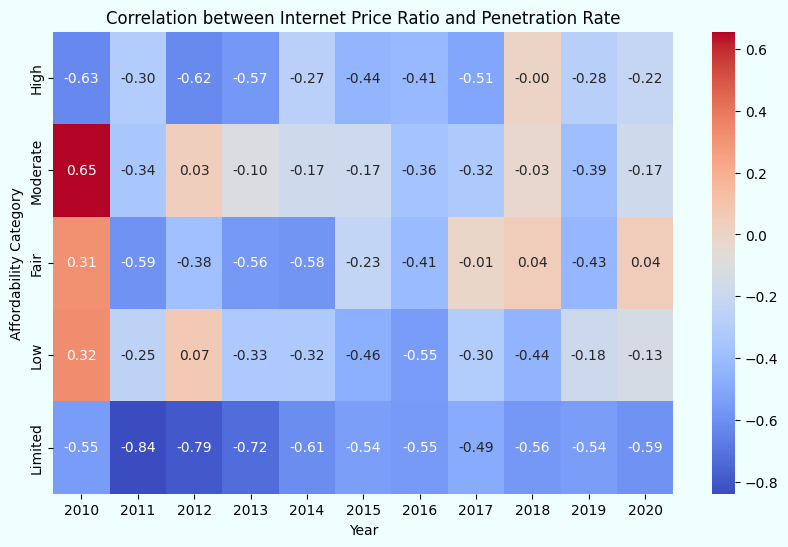

In [14]:
correlation_matrix = df_clean.groupby(['Price Accessibility', 'Year']).apply(
    lambda x: x['Individuals using the Internet, total (%)'].corr(x['Log Internet Price'])
).unstack()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Internet Price Ratio and Penetration Rate')
plt.xlabel('Year')
plt.ylabel('Affordability Category')
plt.show()

This heat map shows the correlation coefficients between each Year and the groups of countries as categorised by their Internet Affordability. As the corelation coefficient approaches 0, a linear relationship between Penetration and Price is highly unlikely. Therefore, for further analysis I will only consider those countries where the internet affordability seems to limit the internet penetration rate. I.e Where the Affordability Category is 'Limited'. It seems that as time has progressed since 2010, internet price has no longer been the disabling factor towards internet access and we endeavour to establish further links between other factors.

## Is the internet a luxury? <a name="conclusion"></a>

The column heads will need renaming as they have been shortened and labelled, however columns of interest include

**x1**	Meal, Inexpensive Restaurant (USD)

**x2**	Meal for 2 People, Mid-range Restaurant, Three-course (USD)

**x28**	One-way Ticket (Local Transport) (USD)

**x29**	Monthly Pass (Regular Price) (USD)

**x36**	Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment (USD)

**x38**	Internet (60 Mbps or More, Unlimited Data, Cable/ADSL) (USD)

**x39**	Fitness Club, Monthly Fee for 1 Adult (USD)

In [15]:
cost_of_living.describe()
#cost_of_living

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x47,x48,x49,x50,x51,x52,x53,x54,x55,data_quality
count,4528.000000,4505.000000,4622.000000,4460.000000,4516.000000,4612.000000,4511.000000,4640.000000,4578.000000,4543.000000,...,4403.000000,3593.000000,3525.000000,3476.000000,3444.000000,2729.000000,2653.000000,3524.000000,3950.000000,4956.000000
mean,10.346705,43.357811,6.929697,3.379774,3.942465,2.754952,1.523873,1.119804,1.148554,1.612855,...,85.976357,711.574943,560.159957,1253.982914,974.082854,3235.270854,2341.933102,1821.186305,6.518030,0.186239
std,7.157058,25.528312,2.704435,2.105957,2.100146,1.358821,0.907025,0.755257,0.517186,1.089164,...,40.434524,648.869301,527.492342,1219.395297,921.331271,6258.792897,3570.623878,1631.465580,5.413828,0.389339
min,0.450000,3.250000,1.080000,0.330000,0.310000,0.220000,0.110000,0.070000,0.260000,0.050000,...,7.600000,21.700000,12.200000,61.510000,27.120000,111.010000,49.240000,18.000000,0.780000,0.000000
25%,4.310000,22.440000,4.980000,1.600000,2.200000,1.580000,0.770000,0.480000,0.830000,0.780000,...,58.430000,256.240000,171.050000,465.200000,325.710000,1120.110000,790.310000,478.980000,3.000000,0.000000
50%,9.600000,40.000000,6.990000,3.000000,3.690000,2.630000,1.480000,1.050000,1.045000,1.320000,...,84.260000,526.870000,403.940000,921.075000,712.830000,2107.490000,1580.620000,1290.840000,5.200000,0.000000
75%,15.000000,60.000000,8.500000,5.000000,5.270000,3.770000,2.110000,1.580000,1.320000,2.200000,...,106.770000,992.610000,790.310000,1710.225000,1369.870000,3843.380000,2798.250000,2770.855000,8.330000,0.000000
max,57.140000,213.690000,22.130000,20.600000,17.500000,10.000000,8.000000,5.850000,6.810000,8.820000,...,542.740000,12608.830000,8989.370000,27397.380000,17868.180000,240963.670000,80321.220000,12821.400000,61.330000,1.000000


In [16]:
# Drop the 'City' column
cost_of_living.drop(columns='city', inplace=True)
# Group by 'Country' and calculate the mean for each column
cost_df = cost_of_living.groupby('country').mean()
# Reset the index to make 'Country' a regular column
cost_df.reset_index(inplace=True)
cost_df

,country,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x47,x48,x49,x50,x51,x52,x53,x54,x55,data_quality
0,Afghanistan,1.690000,6.870000,2.977500,2.260000,NaN,0.597500,0.327500,0.140000,0.512000,...,27.965000,82.317500,46.140000,151.596667,94.163333,486.063333,239.113333,191.463333,11.193333,0.166667
1,Albania,4.460000,25.532000,4.223333,1.378667,1.842667,1.198667,1.148667,0.604000,1.136667,...,77.191429,204.213636,125.985455,366.069000,219.701000,887.849000,536.041111,368.735000,4.880833,0.200000
2,Algeria,1.956562,13.983750,2.830000,1.419615,1.627778,0.507333,0.489091,0.198788,0.673333,...,63.352258,145.281034,96.479630,239.689643,166.367778,947.055789,616.633684,262.671034,6.372667,0.088235
3,American Samoa,23.820000,6.660000,22.130000,1.910000,1.910000,1.000000,1.190000,2.110000,1.050000,...,NaN,89.460000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,Andorra,13.173333,40.920000,7.010000,2.073333,2.600000,1.380000,1.713333,1.370000,0.950000,...,124.693333,823.490000,664.736667,1724.043333,1320.693333,4390.603333,4109.603333,2842.183333,2.843333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Venezuela,8.618824,32.763333,9.021765,1.442353,2.205882,1.928824,1.110000,0.799412,1.508333,...,68.483750,193.940000,181.823333,384.291667,296.666667,665.510000,550.611250,193.140000,31.720000,0.055556
211,Vietnam,2.115882,18.662353,4.231429,0.790625,1.542353,1.689412,0.478824,0.281176,1.337368,...,75.618947,324.830000,201.647273,728.840909,472.695455,1748.847778,986.321111,443.186667,11.003125,0.095238
212,Yemen,6.150000,32.616667,11.158333,2.265000,2.282500,2.540000,1.610000,0.660000,2.298000,...,71.310000,162.295000,93.740000,443.155000,221.605000,2786.350000,1015.360000,439.540000,12.875000,0.142857
213,Zambia,2.988000,18.370000,3.170000,1.152000,1.494000,1.742000,0.822000,0.458000,1.248000,...,105.640000,262.010000,168.400000,832.640000,439.960000,10763.910000,NaN,396.940000,26.000000,0.142857


In [17]:
cost_df.rename(columns={'country': 'Country', 'x2':'Nice Meal', 'x10':'Food Basics(Bread)', 'x20':'Food Basics(Potato)','x23':'Food Basics(Water)', 'x28':'Local Transport single', 'x36':'Basic Utilities', 'x38':'Internet', 'x39':'Gym Membership', 'x41':'Cinema Ticket', 'x42':'Private school', 'x47':'Designer Shoes'}, inplace=True)

In [18]:
cost_df.columns

Index(['Country', 'x1', 'Nice Meal', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'Food Basics(Bread)', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
       'x18', 'x19', 'Food Basics(Potato)', 'x21', 'x22', 'Food Basics(Water)',
       'x24', 'x25', 'x26', 'x27', 'Local Transport single', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'Basic Utilities', 'x37', 'Internet',
       'Gym Membership', 'x40', 'Cinema Ticket', 'Private school', 'x43',
       'x44', 'x45', 'x46', 'Designer Shoes', 'x48', 'x49', 'x50', 'x51',
       'x52', 'x53', 'x54', 'x55', 'data_quality'],
      dtype='object')

In [19]:
cost_df_subset = cost_df[['Country', 'Nice Meal', 'Food Basics(Bread)', 'Food Basics(Potato)', 'Food Basics(Water)', 'Local Transport single', 'Basic Utilities', 'Internet',
       'Gym Membership', 'Cinema Ticket', 'Private school', 'Designer Shoes']]

In [20]:
cost_df_subset

,Country,Nice Meal,Food Basics(Bread),Food Basics(Potato),Food Basics(Water),Local Transport single,Basic Utilities,Internet,Gym Membership,Cinema Ticket,Private school,Designer Shoes
0,Afghanistan,6.870000,0.242500,0.340000,0.226000,0.230000,44.245000,320.150000,11.550000,3.106667,17.795000,27.965000
1,Albania,25.532000,0.592000,0.646667,0.534000,0.471818,81.174667,16.179286,26.956364,5.156154,93.452857,77.191429
2,Algeria,13.983750,0.187419,0.523636,0.270294,0.211429,39.169000,37.448710,14.617742,4.514615,56.711250,63.352258
3,American Samoa,6.660000,3.160000,NaN,NaN,NaN,NaN,81.140000,NaN,NaN,NaN,NaN
4,Andorra,40.920000,1.090000,1.043333,0.760000,1.950000,75.010000,36.996667,54.266667,8.430000,551.460000,124.693333
...,...,...,...,...,...,...,...,...,...,...,...,...
210,Venezuela,32.763333,1.613750,1.272143,1.235714,0.563333,17.490000,45.231765,30.699167,4.882353,64.353750,68.483750
211,Vietnam,18.662353,0.967895,1.138333,0.640526,0.318750,59.219333,9.987368,23.892500,4.147895,163.994444,75.618947
212,Yemen,32.616667,1.100000,2.121667,1.072000,0.600000,70.464000,60.766000,82.715000,NaN,41.074000,71.310000
213,Zambia,18.370000,0.996000,1.572000,0.890000,1.450000,140.690000,103.740000,23.820000,2.000000,171.240000,105.640000


In [21]:
df_clean[df_clean['Year'] == 2020][['Country', 'Price Accessibility']]

,Country,Price Accessibility
10,Albania,Low
21,Algeria,Limited
32,Argentina,Fair
43,Armenia,Low
54,Australia,Moderate
...,...,...
1035,United Kingdom,Moderate
1046,United States,Moderate
1057,Uruguay,Fair
1081,Viet Nam,Fair


In [22]:
merged_df = cost_df_subset.merge(df_clean[df_clean['Year'] == 2020][['Country', 'Price Accessibility']], on='Country', how='inner')
merged_df.dropna(inplace=True)
merged_df_extreme = merged_df[(merged_df['Price Accessibility'] == 'Limited') | (merged_df['Price Accessibility'] == 'High')]
merged_df_limited = merged_df[merged_df['Price Accessibility'] == 'Limited']
merged_df_high = merged_df[merged_df['Price Accessibility'] == 'High']

Here is a basic model that compares the correlation between Internet as a luxury item or as an essential item.

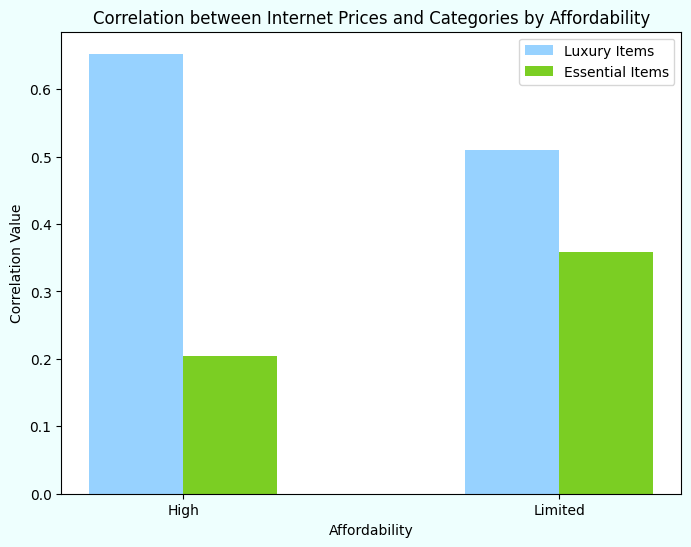

In [23]:
luxury_items = ['Nice Meal', 'Gym Membership']
essential_items = ['Local Transport single', 'Basic Utilities']

# Calculate correlations for high affordability (cheap)
internet_prices_high = merged_df_high['Internet']
luxury_corr_high = internet_prices_high.corr(merged_df_high[luxury_items].mean(axis=1))
essential_corr_high = internet_prices_high.corr(merged_df_high[essential_items].mean(axis=1))

# Calculate correlations for low affordability (expensive)
internet_prices_lim = merged_df_limited['Internet']
luxury_corr_lim = internet_prices_lim.corr(merged_df_limited[luxury_items].mean(axis=1))
essential_corr_lim = internet_prices_lim.corr(merged_df_limited[essential_items].mean(axis=1))

# Create a DataFrame for visualization
data = {
    'Affordability': ['High', 'Limited'],
    'Luxury Items': [luxury_corr_high, luxury_corr_lim],
    'Essential Items': [essential_corr_high, essential_corr_lim]
}
correlation_df = pd.DataFrame(data)

# Plotting the correlations
plt.figure(figsize=(8, 6))

bar_width = 0.25
index = correlation_df.index

plt.bar(index, correlation_df['Luxury Items'], bar_width, label='Luxury Items')
plt.bar(index + bar_width, correlation_df['Essential Items'], bar_width, label='Essential Items')

plt.xlabel('Affordability')
plt.ylabel('Correlation Value')
plt.title('Correlation between Internet Prices and Categories by Affordability')
plt.xticks(index + bar_width / 2, correlation_df['Affordability'])
plt.legend()
plt.show()

There is an interesting contrast that emerges when examining the correlation between luxury and essential items. Across both high and limited affordability brackets, a significantly stronger correlation surfaces between the pricing of luxury items and their availability on the internet market.

It's noteworthy that while essentials among those with limited affordability do display a slightly higher correlation compared to those with high affordability, this difference lacks significance. However, this comparison might overlook certain variables essential to defining luxury and essential items, as I only conisdered two for each. Hence, I conduct a more in-depth analysis below to explore these differences more thoroughly.

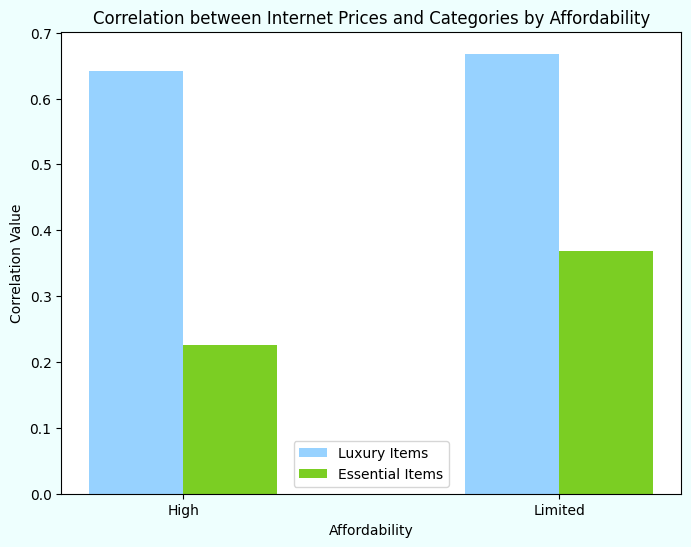

In [24]:
luxury_items = ['Nice Meal', 'Gym Membership', 'Cinema Ticket', 'Private school', 'Designer Shoes']
essential_items = ['Food Basics(Bread)', 'Food Basics(Potato)', 'Food Basics(Water)', 'Local Transport single', 'Basic Utilities']

# Calculate correlations for high affordability (cheap)
internet_prices_high = merged_df_high['Internet']
luxury_corr_high = internet_prices_high.corr(merged_df_high[luxury_items].mean(axis=1))
essential_corr_high = internet_prices_high.corr(merged_df_high[essential_items].mean(axis=1))

# Calculate correlations for low affordability (expensive)
internet_prices_lim = merged_df_limited['Internet']
luxury_corr_lim = internet_prices_lim.corr(merged_df_limited[luxury_items].mean(axis=1))
essential_corr_lim = internet_prices_lim.corr(merged_df_limited[essential_items].mean(axis=1))

# Create a DataFrame for visualization
data = {
    'Affordability': ['High', 'Limited'],
    'Luxury Items': [luxury_corr_high, luxury_corr_lim],
    'Essential Items': [essential_corr_high, essential_corr_lim]
}
correlation_df = pd.DataFrame(data)

# Plotting the correlations
plt.figure(figsize=(8, 6))

bar_width = 0.25
index = correlation_df.index

plt.bar(index, correlation_df['Luxury Items'], bar_width, label='Luxury Items')
plt.bar(index + bar_width, correlation_df['Essential Items'], bar_width, label='Essential Items')

plt.xlabel('Affordability')
plt.ylabel('Correlation Value')
plt.title('Correlation between Internet Prices and Categories by Affordability')
plt.xticks(index + bar_width / 2, correlation_df['Affordability'])
plt.legend()
plt.show()

Despite the inclusion of additional luxury and essential columns in the analysis, the observed correlations between luxury and essential items seem largely unaffected. This persistence suggests that the variables considered might not substantially impact the relationship between these categories. While this outcome challenges my initial hypothesis, it prompts further investigation into potentially overlooked factors that might contribute to the lInternet Penetration across the globe.